In [4]:
import os
import json
import numpy as np
from PIL import Image
from skimage.transform import resize

In [5]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

**Step 1: Preprocessing Data**

In [9]:
# Path to annotation file
annotation_file = r"amateur_drawings_annotations.json"
# Load annotations from JSON file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
# Path to database directory
database_dir = r"amateur_drawings~"
target_size = (256, 256)
num_of_images = 20000
# Extract image paths and annotations
images = []
keypoints = []

for index,annotation in enumerate(annotations['annotations']):
    image_id = annotation['image_id']
    image_info = next((image for image in annotations['images'] if image['id'] == image_id), None)
    if image_info is None:
        # Skip if image info not found
        continue
    image_path = os.path.join(database_dir, image_info['file_name'])
    if not os.path.exists(image_path):
        # Skip if image file does not exist
        continue
        # Define target size for resizing

    origin_img = Image.open(image_path)
    x,y = origin_img.size
#     x = target_size[0]/x
#     y = target_size[0]/y
    img = origin_img.resize(target_size)
    image = np.array(img)  # Load image
    images.append(image)
    filtered_keypoints = [kp for i, kp in enumerate(annotation['keypoints']) if (i % 3 != 2)]#להחפיל את XY בכל חלק מהמערך
    keypoints.append(filtered_keypoints)
    if index == num_of_images:
        break

X = np.array(images)
y = np.array(keypoints)

# Save arrays to files
np.save('images_array.npy', X)
np.save('keypoints_array.npy', y)


OSError: -362610688 requested and 0 written

In [8]:
# Check the shapes of the arrays
print(f"Images shape: {X.shape}")
print(f"Keypoints shape: {y.shape}")

NameError: name 'X' is not defined

In [13]:
# Save arrays to files
np.save('images_array.npy', X)
np.save('keypoints_array.npy', y)

OSError: -362610688 requested and 0 written

**Step 3: Define Model Architecture | Step 4: Compile Model**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Define model architecture
model = Sequential([
    Input(shape=(256, 256, 3)),  # Specify input shape using Input layer
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(34)  # Number of keypoints
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)      

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define model architecture with regularization and batch normalization
model = Sequential([
    Input(shape=(256, 256, 3)),  # Specify input shape using Input layer
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Add dropout for regularization
    Dense(34)  # Number of keypoints
])

# Compile model with a smaller learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train model
history = model.fit(
    np.array(X), 
    np.array(y),
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]  # Add callbacks
)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Epoch 1/100
295/500 [================>.............] - ETA: 4:23 - loss: 9092.5967 - accuracy: 0.2868

**Step 5: Train Model**

In [151]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Train the model with the ModelCheckpoint callback
history = model.fit(
    np.array(images), 
    np.array(keypoints), 
    epochs=200, 
    batch_size=32, 
    validation_split=0.2)


Epoch 1/200
500/500 [==============================] - 518s 1s/step - loss: 7730.9067 - accuracy: 0.4359 - val_loss: 3700.8867 - val_accuracy: 0.4646
Epoch 2/200
500/500 [==============================] - 499s 999ms/step - loss: 3649.0012 - accuracy: 0.4549 - val_loss: 4622.7036 - val_accuracy: 0.4274
Epoch 3/200
500/500 [==============================] - 503s 1s/step - loss: 3353.9861 - accuracy: 0.4704 - val_loss: 3512.2029 - val_accuracy: 0.4959
Epoch 4/200
500/500 [==============================] - 505s 1s/step - loss: 3107.7744 - accuracy: 0.4751 - val_loss: 3580.8823 - val_accuracy: 0.4144
Epoch 5/200
500/500 [==============================] - 506s 1s/step - loss: 2848.6677 - accuracy: 0.4931 - val_loss: 3240.4001 - val_accuracy: 0.4711
Epoch 6/200
500/500 [==============================] - 507s 1s/step - loss: 2597.3464 - accuracy: 0.4907 - val_loss: 3196.9912 - val_accuracy: 0.4816
Epoch 7/200
500/500 [==============================] - 511s 1s/step - loss: 2310.5276 - accuracy:

500/500 [==============================] - 505s 1s/step - loss: 123.2734 - accuracy: 0.6724 - val_loss: 2807.7515 - val_accuracy: 0.4871
Epoch 110/200
500/500 [==============================] - 505s 1s/step - loss: 127.5897 - accuracy: 0.6734 - val_loss: 2784.1174 - val_accuracy: 0.4761
Epoch 111/200
500/500 [==============================] - 505s 1s/step - loss: 127.1269 - accuracy: 0.6712 - val_loss: 2819.0759 - val_accuracy: 0.4806
Epoch 112/200
500/500 [==============================] - 506s 1s/step - loss: 123.2641 - accuracy: 0.6689 - val_loss: 2847.9451 - val_accuracy: 0.4714
Epoch 113/200
500/500 [==============================] - 505s 1s/step - loss: 124.7336 - accuracy: 0.6692 - val_loss: 2865.6841 - val_accuracy: 0.4764
Epoch 114/200
500/500 [==============================] - 505s 1s/step - loss: 120.9604 - accuracy: 0.6719 - val_loss: 2801.0618 - val_accuracy: 0.4719
Epoch 115/200
500/500 [==============================] - 504s 1s/step - loss: 121.5872 - accuracy: 0.6684 - 

In [152]:
model.save("keypoint_detection_model_new_and_good.h5")

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model
model_path = "keypoint_detection_model_new_and_good5.h5"
model = load_model(model_path)

In [12]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize the image
    return image

# Function to post-process predictions
def postprocess_keypoints(keypoints, original_size, target_size=(256, 256)):
    keypoints = np.array(keypoints).reshape(-1, 2)
    keypoints[:, 0] *= target_size[0] / original_size[0]
    keypoints[:, 1] *= target_size[1] / original_size[1]
    return keypoints

# Load and preprocess the image
image_path =  r"C:\Users\tichnut\Desktop\my_project\final_project\connection_react\uploads\1e45a440b8ed49c081ecf2a6a9529582.png" 
preprocessed_image = preprocess_image(image_path)
original_size = preprocessed_image.shape

# Predict keypoints
predicted_keypoints = model.predict(preprocessed_image)
predicted_keypoints1 =  postprocess_keypoints(predicted_keypoints, original_size)


1/1 [==============================] - 0s 29ms/step


In [13]:
predicted_keypoints = predicted_keypoints.reshape(-1, 2)
predicted_keypoints

array([[181.1015 , 181.6735 ],
       [189.40784, 172.15756],
       [173.2519 , 174.74672],
       [201.66762, 178.66188],
       [155.66135, 184.6382 ],
       [190.08485, 219.51663],
       [170.17798, 219.34961],
       [209.38065, 227.68257],
       [148.92569, 221.98766],
       [224.55237, 225.98193],
       [139.29478, 228.72311],
       [185.63336, 262.11826],
       [168.47997, 265.01923],
       [195.16501, 280.7591 ],
       [164.514  , 280.597  ],
       [205.55057, 301.1371 ],
       [152.5737 , 304.4249 ]], dtype=float32)

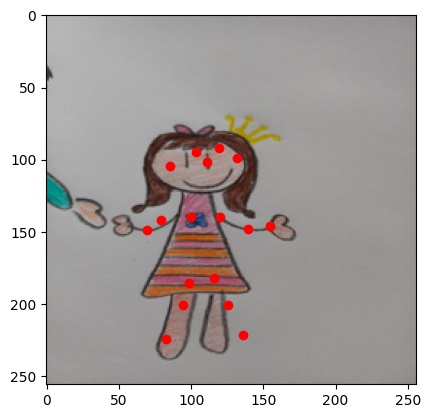

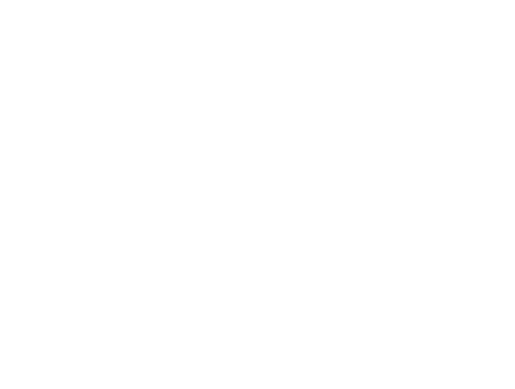

In [21]:
target_size=(256, 256)
origin_img = Image.open(image_path)
img = origin_img.resize(target_size)
image = np.array(img)  # Load image
plt.imshow(image)
for (x, y) in predicted_keypoints:
    plt.plot(x-70, y-80, 'ro')
plt.show()
plt.axis('off')  # Turn off the axis
plt.show()

ValueError: too many values to unpack (expected 2)

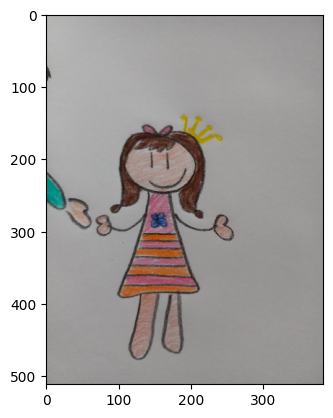

In [26]:
# Plot the image and keypoints
def plot_keypoints(image_path, keypoints):
    image = plt.imread(image_path)
    plt.imshow(image)
    for (x, y) in keypoints:
        plt.plot(x, y, 'ro')
    plt.show()

# Plot the keypoints on the image
plot_keypoints(image_path, predicted_keypoints)

In [35]:
# Print model summary

checkpoint_path ="keypoint_detection_model_new_and_good5.h5"
# Define the checkpoint callback to save the model
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# Train or continue training the model
history = model.fit(
    np.array(images), 
    np.array(keypoints), 
    epochs=300,  # You can adjust the number of epochs as needed
    batch_size=32, 
    validation_split=0.2,
)
model.save("keypoint_detection_model_new_and_good6.h5")

Epoch 1/300
500/500 [==============================] - 531s 1s/step - loss: 50.4233 - accuracy: 0.8067 - val_loss: 2586.9199 - val_accuracy: 0.4664
Epoch 2/300
500/500 [==============================] - 521s 1s/step - loss: 49.3182 - accuracy: 0.8102 - val_loss: 2622.4277 - val_accuracy: 0.4751
Epoch 3/300
500/500 [==============================] - 492s 985ms/step - loss: 48.5404 - accuracy: 0.8114 - val_loss: 2593.7615 - val_accuracy: 0.4739
Epoch 4/300
500/500 [==============================] - 482s 965ms/step - loss: 48.5209 - accuracy: 0.8176 - val_loss: 2646.4766 - val_accuracy: 0.4709
Epoch 5/300
500/500 [==============================] - 491s 982ms/step - loss: 50.0663 - accuracy: 0.8033 - val_loss: 2570.8818 - val_accuracy: 0.4729
Epoch 6/300
500/500 [==============================] - 499s 998ms/step - loss: 50.7675 - accuracy: 0.8079 - val_loss: 2638.2688 - val_accuracy: 0.4799
Epoch 7/300
500/500 [==============================] - 484s 968ms/step - loss: 47.9461 - accuracy: 0

Epoch 55/300
500/500 [==============================] - 467s 935ms/step - loss: 46.7234 - accuracy: 0.8107 - val_loss: 2588.9570 - val_accuracy: 0.4801
Epoch 56/300
500/500 [==============================] - 465s 930ms/step - loss: 46.7209 - accuracy: 0.8084 - val_loss: 2569.3076 - val_accuracy: 0.4754
Epoch 57/300
500/500 [==============================] - 464s 928ms/step - loss: 46.1174 - accuracy: 0.8146 - val_loss: 2597.7832 - val_accuracy: 0.4651
Epoch 58/300
500/500 [==============================] - 464s 929ms/step - loss: 45.7297 - accuracy: 0.8161 - val_loss: 2617.3918 - val_accuracy: 0.4701
Epoch 59/300
500/500 [==============================] - 466s 932ms/step - loss: 46.0047 - accuracy: 0.8108 - val_loss: 2598.9163 - val_accuracy: 0.4776
Epoch 60/300
500/500 [==============================] - 466s 931ms/step - loss: 48.0052 - accuracy: 0.8112 - val_loss: 2603.7339 - val_accuracy: 0.4776
Epoch 61/300
500/500 [==============================] - 465s 930ms/step - loss: 47.5136 

Epoch 109/300
500/500 [==============================] - 466s 932ms/step - loss: 43.6677 - accuracy: 0.8114 - val_loss: 2584.1646 - val_accuracy: 0.4669
Epoch 110/300
500/500 [==============================] - 465s 930ms/step - loss: 45.0910 - accuracy: 0.8110 - val_loss: 2567.9880 - val_accuracy: 0.4669
Epoch 111/300
500/500 [==============================] - 465s 931ms/step - loss: 44.6365 - accuracy: 0.8138 - val_loss: 2557.3237 - val_accuracy: 0.4779
Epoch 112/300
500/500 [==============================] - 466s 931ms/step - loss: 44.1644 - accuracy: 0.8208 - val_loss: 2572.4536 - val_accuracy: 0.4726
Epoch 113/300
500/500 [==============================] - 466s 932ms/step - loss: 42.8842 - accuracy: 0.8143 - val_loss: 2572.1462 - val_accuracy: 0.4681
Epoch 114/300
500/500 [==============================] - 469s 939ms/step - loss: 42.5821 - accuracy: 0.8166 - val_loss: 2595.4114 - val_accuracy: 0.4616
Epoch 115/300
500/500 [==============================] - 468s 935ms/step - loss: 4

500/500 [==============================] - 470s 940ms/step - loss: 42.5572 - accuracy: 0.8102 - val_loss: 2535.3181 - val_accuracy: 0.4791
Epoch 216/300
500/500 [==============================] - 470s 940ms/step - loss: 40.2835 - accuracy: 0.8254 - val_loss: 2564.8926 - val_accuracy: 0.4631
Epoch 217/300
500/500 [==============================] - 469s 938ms/step - loss: 39.4679 - accuracy: 0.8166 - val_loss: 2558.6917 - val_accuracy: 0.4676
Epoch 218/300
500/500 [==============================] - 469s 937ms/step - loss: 39.7636 - accuracy: 0.8127 - val_loss: 2559.3718 - val_accuracy: 0.4574
Epoch 219/300
500/500 [==============================] - 470s 939ms/step - loss: 38.6777 - accuracy: 0.8202 - val_loss: 2555.5444 - val_accuracy: 0.4686
Epoch 220/300
500/500 [==============================] - 468s 936ms/step - loss: 41.9259 - accuracy: 0.8201 - val_loss: 2566.4497 - val_accuracy: 0.4721
Epoch 221/300
500/500 [==============================] - 470s 940ms/step - loss: 41.7050 - accur

In [188]:
model.save("keypoint_detection_model_new_and_good2.h5")

In [195]:
checkpoint